In [13]:
import pickle
from pathlib import Path
import os
import numpy as np
from itertools import chain
from nilearn import datasets, plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.axes import Axes
import xarray as xr
#import significantdigits as sd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap 
import scipy.stats
import nibabel as nib
import pandas as pd
import netCDF4

In [3]:
def create_xarray(data, fm_version):
    subjects = sorted(data.keys())
    pipelines = sorted(set(chain.from_iterable(d.keys() for d in data.values())))
    iterations = min(len(b) for a in data.values() for b in a.values())
    
    (k,) = set(
        chain.from_iterable(c.shape for a in data.values() for b in a.values() for c in b)
    )

    schaefer_atlas = datasets.fetch_atlas_schaefer_2018(
        n_rois=400, yeo_networks=7, resolution_mm=1
    )
    schaefer_atlas_labels = list(map(bytes.decode, schaefer_atlas["labels"]))
    indices = np.tril_indices(k, -1)
    labels = np.array(
        [
            f"{schaefer_atlas_labels[i]}, {schaefer_atlas_labels[j]}"
            for i, j in zip(*indices)
        ]
    )

    arrays = []
    version_labels = np.array([fm_version] * iterations)  # Assign "fm20" or "fm24"

    for subject in subjects:
        subject_arrays = []
        for pipeline in pipelines:
            array = np.dstack(data[subject][pipeline])[
                *indices, :iterations, np.newaxis, np.newaxis
            ]
            subject_arrays.append(array)
        
        subject_array = np.concatenate(subject_arrays, axis=2) #Stack across pipelines
        arrays.append(subject_array)

    array = np.concatenate(arrays, axis=3)  #Stack across subjects
    
    # Old approach with iteration+version labels
    iteration_labels = [f"{i}_{fm_version}" for i in range(iterations)] # define iteration labels globally  
    assert array.shape[1] == len(iteration_labels), (
        f"Iteration mismatch: data shape {array.shape[1]} vs labels {len(iteration_labels)}"
    )

    return xr.Dataset(
        {"functional_connectivity": (["cell", "iteration", "pipeline", "subject"], array)},
        coords=dict(
            cell=labels, 
            iteration=version_labels, 
            # other options are range(iterations) (naming=1,2,3...) or iteration_labels (naming=1_fm20, 2_fm20...)so on
            pipeline=pipelines, 
            subject=subjects,
            # version=("iteration", version_labels),  # This would categorize iterations into fm20 or fm24 by creating a sub-group
        ),
    )



In [15]:
data_fm20 = pickle.load(open('fm20_feature-matrices.pkl', 'rb'))
data_fm24 = pickle.load(open('fm24_feature-matrices.pkl', 'rb'))
ds_fm20 = create_xarray(data_fm20, "fm20")
ds_fm24 = create_xarray(data_fm24, "fm24")


[get_dataset_dir] Dataset found in /home/vcespedes/nilearn_data/schaefer_2018
[get_dataset_dir] Dataset found in /home/vcespedes/nilearn_data/schaefer_2018


In [7]:
len(data_fm20["sub-13192"]["GSR"]) 
len(data_fm20["sub-01"]["GSR"]) 

99

In [17]:
ds_combined = xr.concat([ds_fm20, ds_fm24], dim="iteration") # Merge datasets along the 'iteration' dimension
ds_combined

<xarray.Dataset> Size: 7GB
Dimensions:                  (cell: 79800, iteration: 200, pipeline: 14,
                              subject: 4)
Coordinates:
  * cell                     (cell) <U76 24MB '7Networks_LH_Vis_2, 7Networks_...
  * iteration                (iteration) <U4 3kB 'fm20' 'fm20' ... 'fm24' 'fm24'
  * pipeline                 (pipeline) <U24 1kB 'GSR' ... 'simpleScrubbingGSR'
  * subject                  (subject) <U9 144B 'sub-01' 'sub-09' ... 'sub-9040'
Data variables:
    functional_connectivity  (cell, iteration, pipeline, subject) float64 7GB ...

In [ ]:
ds_combined.to_netcdf("ds_combined.nc", engine="netcdf4")

In [30]:
# print(ds_combined.iteration.values)
print("Subjects:", ds_combined.coords["subject"].values)

for idx, pipeline in enumerate(ds_combined.coords["pipeline"].values):
    print(f"{idx}: {pipeline}")

print(ds_combined["functional_connectivity"].shape)


Subjects: ['sub-01' 'sub-09' 'sub-13192' 'sub-9040']
0: GSR
1: aCompCor
2: icaAroma
3: icaAromaACompCor
4: icaAromaGSR
5: icaAromaMotionParameters
6: icaAromaSimple
7: icaAromaSimpleGSR
8: motionParameters
9: noConfounds
10: simple
11: simpleGSR
12: simpleScrubbing
13: simpleScrubbingGSR
(79800, 273, 14, 4)


<Axes: ylabel='Count'>

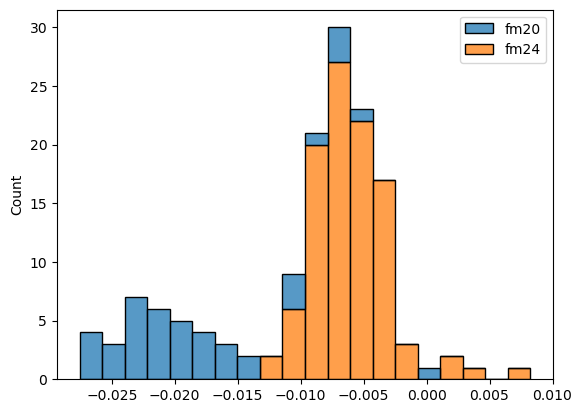

In [97]:
# sns.histplot(ds_combined.functional_connectivity[59334, :, 5, 0], bins=20, stat="count")
sns.histplot(
    x=ds_combined.functional_connectivity[51122, :, 9, 0].values,
    hue=["fm20" if "fm20" in it else "fm24" for it in ds_combined.iteration.values],
    bins=20, stat="count", multiple="stack"
)

In [ ]:
def permute_iterations(ds: xr.Dataset) -> xr.Dataset:
    """
    Randomly shuffles the iteration labels within each subject and pipeline.
    """
    permuted_ds = ds.copy()
    subjects = ds.subject.values
    pipelines = ds.pipeline.values
    for subject in subjects:
        for pipeline in pipelines:
            shuffled_data = permuted_ds.functional_connectivity.loc[:, :, pipeline, subject].values.copy()
            np.random.shuffle(shuffled_data)  # Shuffle in place            
            permuted_ds["functional_connectivity"].loc[:, :, pipeline, subject] = shuffled_data

    return permuted_ds



def plot_cell(ds: xr.Dataset, cell_index=51122, pipeline_index=9, subject_index=0):
    data = ds.functional_connectivity[cell_index, :, pipeline_index, subject_index].values
    hue_labels = ["fm20" if "fm20" in it else "fm24" for it in ds.iteration.values]
    plt.figure(figsize=(10, 6))
    sns.histplot(x=data, hue=hue_labels, bins=20, stat="count", multiple="stack")
    plt.xlabel("Functional Connectivity Value")
    plt.ylabel("Count")
    plt.title(f"Distribution for Cell {cell_index}, Pipeline {pipeline_index}, Subject {subject_index}")
    plt.show()


# def main():
#     # ds_combined = xr.open_dataset("ds_combined.nc")
#     ds_permuted = permute_iterations(ds_combined)
#     plot_cell(ds_permuted)
#     plot_cell(ds_combined)
#     # Save permuted dataset if needed
#     # permuted_ds.to_netcdf("permuted_dataset.nc")

# if __name__ == "__main__":
#     main()

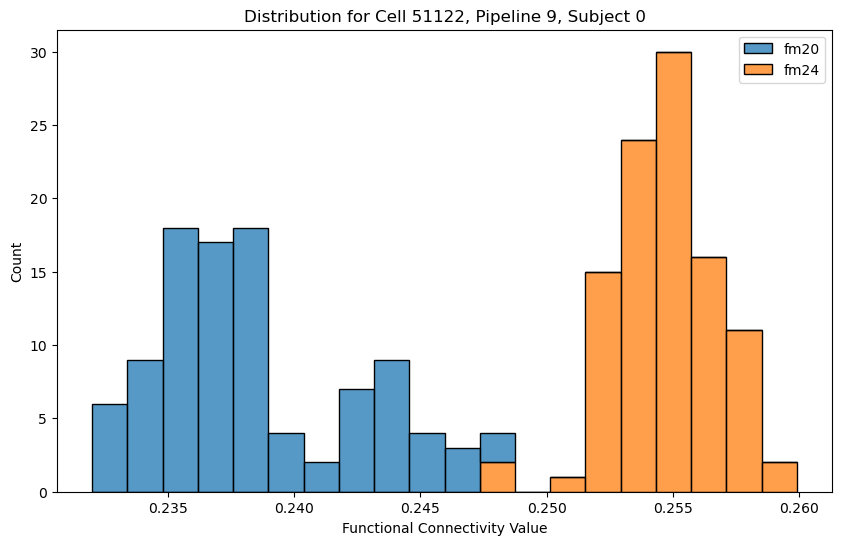

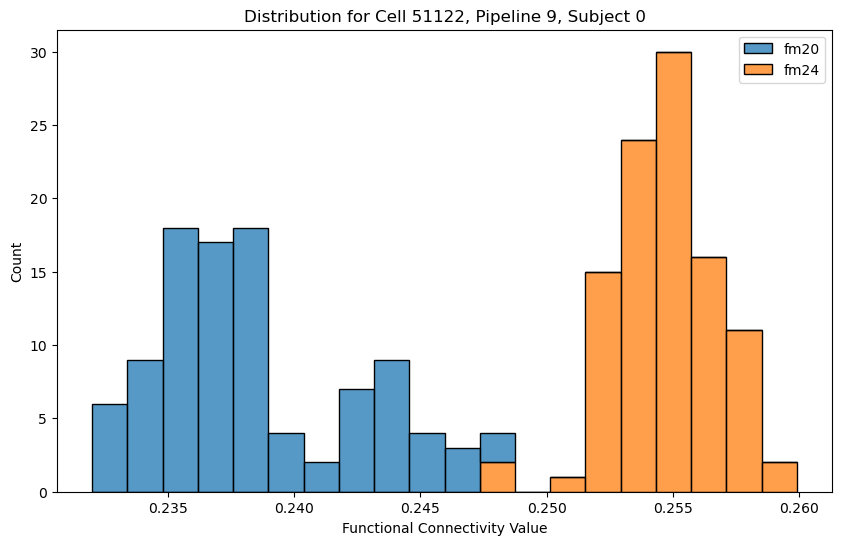

In [32]:
ds_permuted = permute_iterations(ds_combined)
plot_cell(ds_permuted)
plot_cell(ds_combined)
